In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
data = []
with open('arxiv-metadata-oai-snapshot.json', 'r') as f:
    for i, line in enumerate(f):
        data.append(json.loads(line))
        if i >= 49999:
            break

print(f"Loaded {len(data)} articles")

Loaded 50000 articles


In [4]:
df = pd.DataFrame(data)
print("\n" + "="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"\nDimensions: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nAvailable columns:\n{df.columns.tolist()}")


DATASET INFORMATION

Dimensions: 50000 rows × 14 columns

Available columns:
['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed']


In [5]:
print("\n" + "="*60)
print("FIRST 3 ARTICLES")
print("="*60)
print(df.head(3))

print("\n" + "="*60)
print("COLUMN INFORMATION")
print("="*60)
print(df.info())

print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Columns': missing.index,
    'Missing Values': missing.values,
    'Percent (%)': missing_pct.values
})
print(missing_df[missing_df['Missing Values'] > 0])


FIRST 3 ARTICLES
          id       submitter  \
0  0704.0001  Pavel Nadolsky   
1  0704.0002    Louis Theran   
2  0704.0003     Hongjun Pan   

                                             authors  \
0  C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...   
1                    Ileana Streinu and Louis Theran   
2                                        Hongjun Pan   

                                               title  \
0  Calculation of prompt diphoton production cros...   
1           Sparsity-certifying Graph Decompositions   
2  The evolution of the Earth-Moon system based o...   

                                  comments               journal-ref  \
0  37 pages, 15 figures; published version  Phys.Rev.D76:013009,2007   
1    To appear in Graphs and Combinatorics                      None   
2                      23 pages, 3 figures                      None   

                          doi         report-no      categories  \
0  10.1103/PhysRevD.76.013009  ANL-HEP-PR-07-12

In [6]:
print("CATEGORY ANALYSIS")
print("="*60)

df['primary_category'] = df['categories'].str.split().str[0]

print(f"\nTotal unique categories: {df['primary_category'].nunique()}")
print(f"\nTop 15 most popular categories:")
print(df['primary_category'].value_counts().head(15))

CATEGORY ANALYSIS

Total unique categories: 133

Top 15 most popular categories:
primary_category
astro-ph              9208
hep-ph                3591
hep-th                3020
quant-ph              2646
gr-qc                 1670
cond-mat.mtrl-sci     1526
cond-mat.mes-hall     1506
cond-mat.str-el       1345
cond-mat.stat-mech    1232
math-ph               1047
nucl-th                960
math.AG                955
math.PR                943
cond-mat.other         822
cond-mat.supr-con      816
Name: count, dtype: int64


In [7]:
print("\n" + "="*60)
print("TEMPORAL ANALYSIS")
print("="*60)

df['update_date'] = pd.to_datetime(df['update_date'])
df['year'] = df['update_date'].dt.year
df['month'] = df['update_date'].dt.month

print(f"\nPeriod covered: {df['year'].min()} - {df['year'].max()}")
print(f"\nArticles per year (last 10 years):")
print(df['year'].value_counts().sort_index().tail(10))


TEMPORAL ANALYSIS

Period covered: 2007 - 2025

Articles per year (last 10 years):
year
2016    577
2017    311
2018    110
2019    530
2020    107
2021     73
2022     61
2023     41
2024     48
2025     32
Name: count, dtype: int64


In [8]:
print("\n" + "="*60)
print("AUTHOR ANALYSIS")
print("="*60)

df['num_authors'] = df['authors'].str.split(',').str.len()
print(f"\nAuthor count statistics per article:")
print(df['num_authors'].describe())


AUTHOR ANALYSIS

Author count statistics per article:
count    50000.000000
mean         3.068580
std          4.782566
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        241.000000
Name: num_authors, dtype: float64


In [9]:
print("\n" + "="*60)
print("ABSTRACT ANALYSIS")
print("="*60)

df['abstract_length'] = df['abstract'].str.len()
print(f"\nAbstract length statistics (characters):")
print(df['abstract_length'].describe())


ABSTRACT ANALYSIS

Abstract length statistics (characters):
count    50000.000000
mean       792.864640
std        402.027925
min         20.000000
25%        499.000000
50%        719.000000
75%       1030.000000
max       2864.000000
Name: abstract_length, dtype: float64



GENERATING VISUALIZATIONS...
Visualizations saved to 'arxiv_initial_exploration.png'


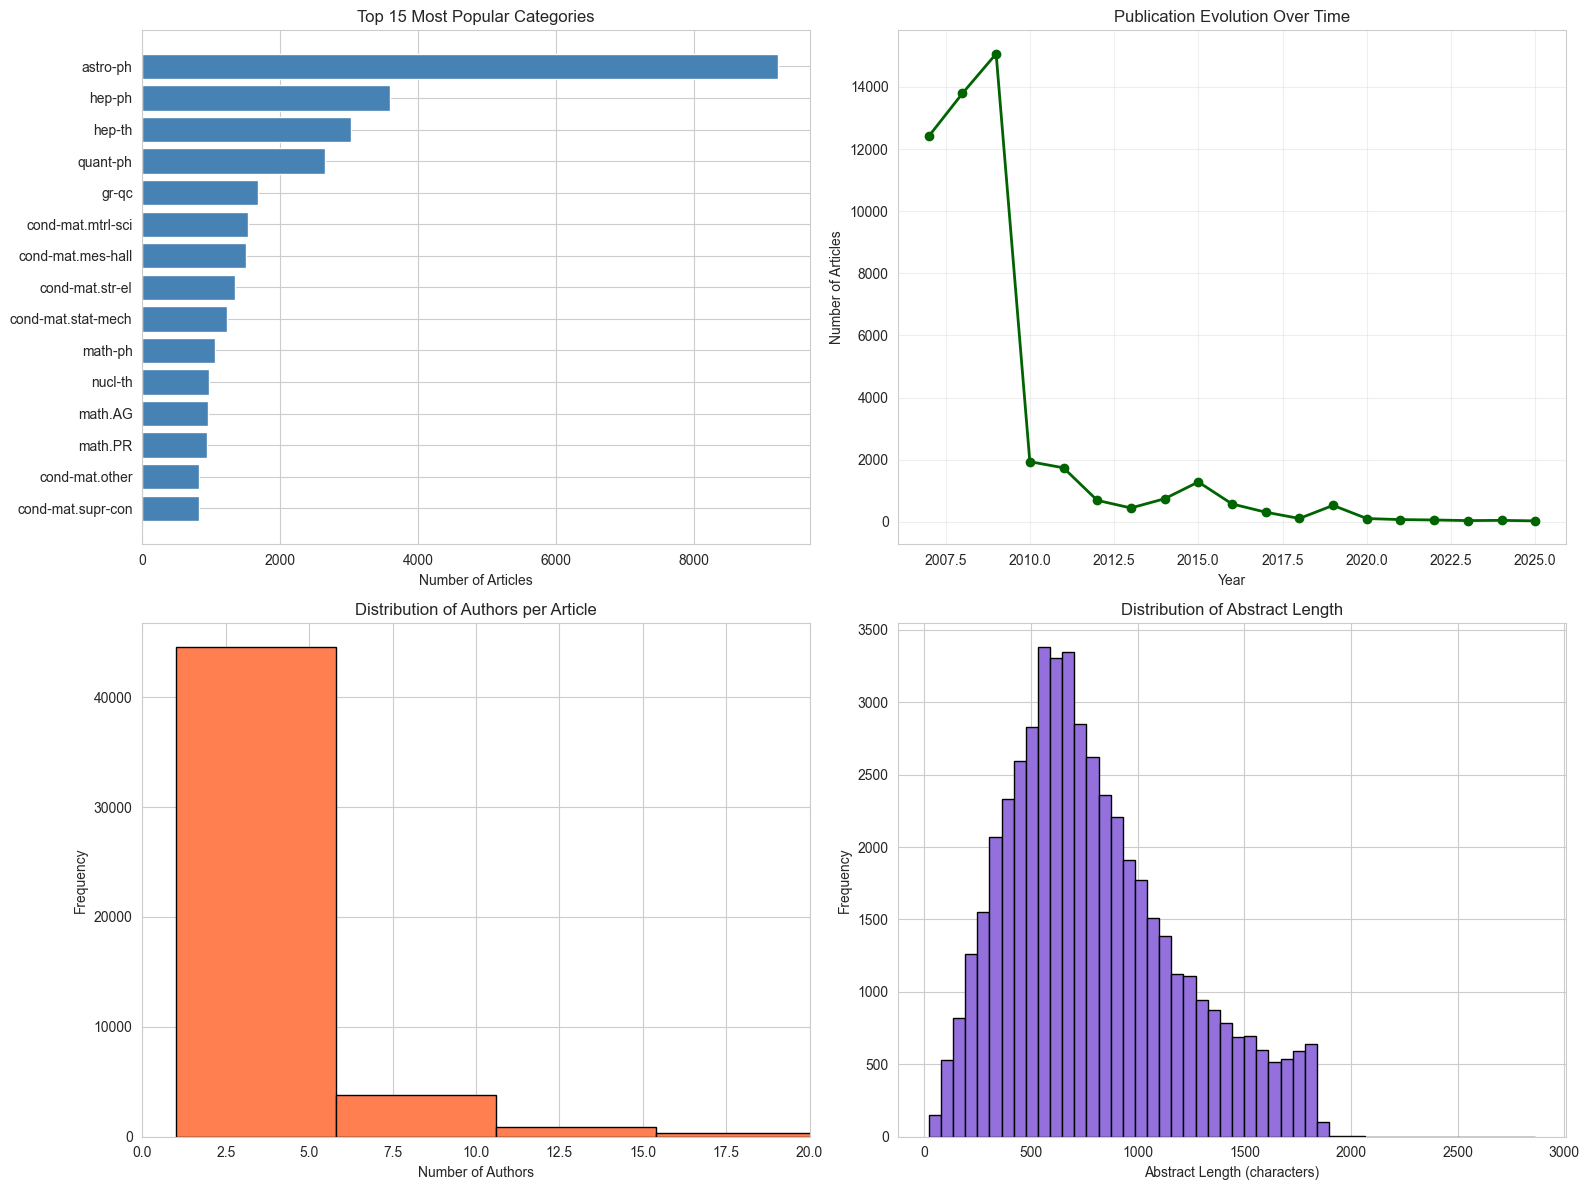

In [10]:
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS...")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

top_cats = df['primary_category'].value_counts().head(15)
axes[0, 0].barh(range(len(top_cats)), top_cats.values, color='steelblue')
axes[0, 0].set_yticks(range(len(top_cats)))
axes[0, 0].set_yticklabels(top_cats.index)
axes[0, 0].set_xlabel('Number of Articles')
axes[0, 0].set_title('Top 15 Most Popular Categories')
axes[0, 0].invert_yaxis()

yearly_counts = df['year'].value_counts().sort_index()
axes[0, 1].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, color='darkgreen')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Number of Articles')
axes[0, 1].set_title('Publication Evolution Over Time')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(df['num_authors'].dropna(), bins=50, color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Number of Authors')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Authors per Article')
axes[1, 0].set_xlim(0, 20)

axes[1, 1].hist(df['abstract_length'].dropna(), bins=50, color='mediumpurple', edgecolor='black')
axes[1, 1].set_xlabel('Abstract Length (characters)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Abstract Length')

plt.tight_layout()
plt.savefig('arxiv_initial_exploration.png', dpi=300, bbox_inches='tight')
print("Visualizations saved to 'arxiv_initial_exploration.png'")
plt.show()

In [11]:
df.to_pickle('arxiv_sample_processed.pkl')
print("Processed dataset saved to 'arxiv_sample_processed.pkl'")

Processed dataset saved to 'arxiv_sample_processed.pkl'
